O serviço de vendas de carros usados Rusty Bargain está desenvolvendo um aplicativo para atrair novos clientes. Nesse aplicativo, você pode descobrir rapidamente o valor de mercado do seu carro. Você tem acesso a dados históricos: especificações técnicas, versões de acabamento e preços. Você precisa construir o modelo para determinar o valor. 

Rusty Bargain está interessado em:

- a qualidade da predição;
- a velocidade da predição;
- o tempo necessário para o treinamento

In [4]:
import pandas as pd
import numpy as np
import re
import time
import timeit
import lightgbm as lgb
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

## Preparação de Dados

In [5]:
df = pd.read_csv('./datasets/car_data.csv')
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
255700,07/03/2016 21:51,9000,bus,2007,manual,105,touran,125000,5,gasoline,volkswagen,NaN,07/03/2016 00:00,0,78628,06/04/2016 03:45
127026,15/03/2016 21:40,500,sedan,1991,manual,75,golf,150000,7,petrol,volkswagen,no,15/03/2016 00:00,0,71272,24/03/2016 13:45
254188,09/03/2016 12:46,1350,small,2000,manual,75,clio,150000,5,petrol,renault,no,09/03/2016 00:00,0,67678,03/04/2016 22:16
179339,29/03/2016 19:54,0,small,1996,manual,50,fiesta,125000,7,petrol,ford,NaN,29/03/2016 00:00,0,39624,06/04/2016 06:15
295012,08/03/2016 11:36,1200,wagon,1999,manual,75,3er,150000,0,NaN,bmw,yes,08/03/2016 00:00,0,13587,12/03/2016 19:17


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Renomeando as colunas para snake_case

In [7]:
# Criando a variável columns_new com os nomes das colunas em uma lista
columns_new = df.columns

# Transformando a lista em string para poder usar regex
string_columns = '/'.join(columns_new)

# Usando Expressões Regulares (Regex) para alterar as strings inserindo um espaço antes das letras maiúsculas
regex_columns = re.sub('(?=[A-Z])', ' ', string_columns)
regex_columns = regex_columns.split('/')

print(regex_columns)

[' Date Crawled', ' Price', ' Vehicle Type', ' Registration Year', ' Gearbox', ' Power', ' Model', ' Mileage', ' Registration Month', ' Fuel Type', ' Brand', ' Not Repaired', ' Date Created', ' Number Of Pictures', ' Postal Code', ' Last Seen']


In [8]:
# Criando a lista vazia para anexar os nomes das colunas após transformações
new_col_names = []

# Criando loop para renomear todas as colunas em snake_case
for name in regex_columns:
    name_stripped = name.strip()
    name_lowered = name_stripped.lower()
    name_no_spaces = name_lowered.replace(' ', '_')
    
    new_col_names.append(name_no_spaces)

# Renomeando as colunas do DataFrame com os nomes modificados anteriormente
df.columns = new_col_names
df.sample(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
249157,18/03/2016 14:06,500,NaN,2005,manual,60,corsa,150000,0,NaN,opel,yes,18/03/2016 00:00,0,56566,26/03/2016 04:17
304533,12/03/2016 16:54,1500,sedan,1994,manual,116,passat,90000,3,petrol,volkswagen,no,12/03/2016 00:00,0,22043,12/03/2016 16:54
189138,28/03/2016 18:39,1750,sedan,1990,manual,90,golf,150000,5,petrol,volkswagen,NaN,28/03/2016 00:00,0,64850,28/03/2016 18:39
203405,10/03/2016 09:57,2300,NaN,2018,manual,0,NaN,5000,0,petrol,audi,no,10/03/2016 00:00,0,40233,10/03/2016 09:57
140321,25/03/2016 20:40,1150,small,2002,manual,58,corsa,150000,4,petrol,opel,yes,25/03/2016 00:00,0,91154,07/04/2016 02:45


### Checagem de duplicados

In [9]:
df.duplicated().sum()

262

In [10]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

### Remoção de colunas desnecessárias

Algumas colunas não trazem informações que tenham correlação com o preço do veículo (target). Por este motivo vamos removê-las para evitar o overfitting e também reduzir o tempo de treinamento dos nossos modelos.

In [11]:
df = df.drop((['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']), axis=1)

In [12]:
df.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN


### Análise individual das colunas numéricas

In [13]:
df.describe()

,price,registration_year,power,mileage
count,354107.000000,354107.000000,354107.000000,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684
std,4514.338584,90.261168,189.914972,37906.590101
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


#### Coluna registration_year

A coluna 'registration_year', apresenta algumas informações equivocadas que observamos ao analisar o valor mínimo e o máximo.  
Vamos investigar a coluna de uma forma mais aprofundada.

In [14]:
df['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

A coluna apresenta valores sem sentido para a informação de ano. Acima de 2019, já temos o ano de 2066 e, a partir daí várias informações equivocadas que iremos remover.  
Vamos remover também anos anteriores ao ano de 1960, pois não nos interessam carros tão antigos. Dessa forma já eliminaremos também muitas linhas que contém anos anteriores a 1800, obviamente informações equivocadas.

In [15]:
df = df.query("registration_year > 1960 and registration_year < 2020")

df['registration_year'].sort_values().unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019], dtype=int64)

In [16]:
df.shape

(353392, 10)

#### Coluna price

Como essa coluna é nosso target, vamos realizar uma análise de outliers mais detalhada

In [17]:
df['price'].value_counts()

price
0        10617
500       5649
1500      5382
1000      4635
1200      4587
         ...  
7435         1
16845        1
17159        1
7396         1
10985        1
Name: count, Length: 3731, dtype: int64

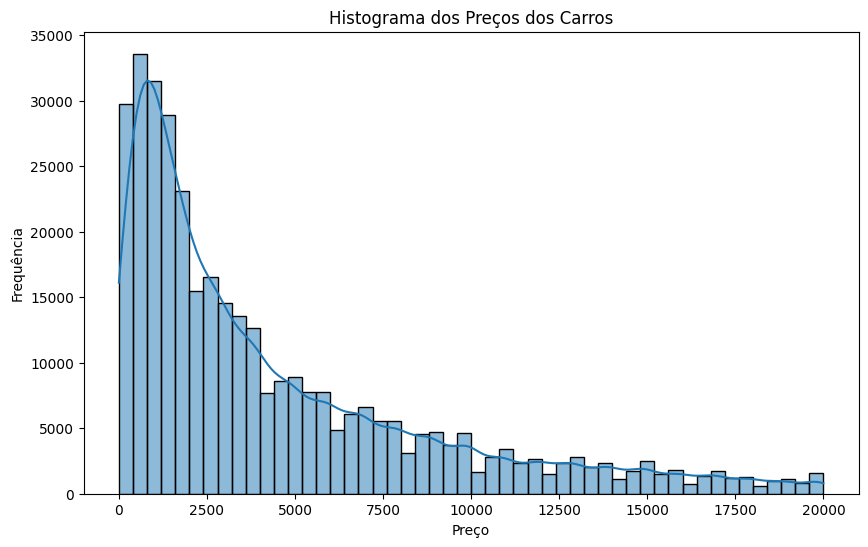

In [18]:
# Traçando histograma para análise dos dados da coluna target
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Histograma dos Preços dos Carros')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

Analisando o histograma, podemos observar que muitos carros estão lançados com preço 0 ou muito baixo.  
Em relação aos preços altos, os valores não ultrapassam $20,000. Precisamos analisar mais detalhadamente os outliers, mas não existe nenhum valor que está muito acima e com características claras de outlier.

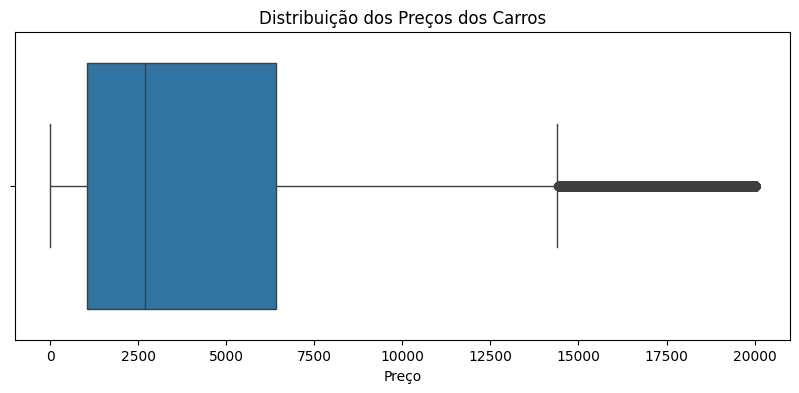

In [19]:
# Traçando um boxplot para análise de outliers

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['price'])
plt.title('Distribuição dos Preços dos Carros')
plt.xlabel('Preço')
plt.show()

Interquartile Range (IQR)
O IQR é a diferença entre o terceiro quartil (Q3) e o primeiro quartil (Q1).  

Valores abaixo de 𝑄1 − 1.5 × 𝐼𝑄𝑅 ou acima de 𝑄3 + 1.5 × 𝐼𝑄𝑅 são considerados outliers.

In [20]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print('upper_bound:', upper_bound)
print()
print(f"Number of outliers: {len(outliers)}")

upper_bound: 14417.5

Number of outliers: 18888


Analisando outliers através do IQR, observamos que pelo método, temos 18.888 outliers, pois os preços acima de $14.417,50 foram considerados outliers, mas se tratando do mercado de veículos, precisamos analisar se estes são de fato outliers ou se tratam realmente de modelos de luxo, mais valorizados no mercado.

In [21]:
# Checando as marcas com mais outliers
outliers['brand'].value_counts()

brand
volkswagen        3935
bmw               3443
audi              3159
mercedes_benz     3013
ford               775
opel               532
mini               521
skoda              354
sonstige_autos     286
nissan             272
porsche            263
seat               225
hyundai            203
kia                176
renault            176
peugeot            176
volvo              175
toyota             161
mazda              141
chevrolet          118
land_rover         104
citroen             84
jeep                76
mitsubishi          70
fiat                68
alfa_romeo          67
jaguar              65
honda               60
chrysler            43
subaru              39
suzuki              38
smart               23
dacia               21
saab                18
lancia               5
trabant              2
rover                1
Name: count, dtype: int64

As marcas que apresentam mais outliers são de fato marcas que possuem carros com preço mais elevado. Vamos checar algumas marcas para conferir se existe algum padrão de erro ou se de fato os preços tendem a estar corretos.

In [22]:
out_volks = outliers[outliers['brand'] == 'volkswagen']
out_volks.sample(10)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
24742,19200,suv,2011,auto,140,tiguan,80000,gasoline,volkswagen,NaN
70535,15999,sedan,2011,manual,211,golf,90000,petrol,volkswagen,no
76484,19800,sedan,2010,auto,239,phaeton,125000,gasoline,volkswagen,no
312150,15500,bus,2013,auto,122,golf,40000,petrol,volkswagen,no
176527,16750,sedan,2013,auto,150,golf,100000,gasoline,volkswagen,no
183041,16999,sedan,2013,manual,140,golf,40000,petrol,volkswagen,no
2345,19199,coupe,2012,manual,170,scirocco,60000,gasoline,volkswagen,no
287,16150,suv,2011,manual,150,tiguan,30000,petrol,volkswagen,no
282445,16950,sedan,2014,auto,150,golf,60000,gasoline,volkswagen,no
269048,14850,bus,2012,auto,140,touran,40000,petrol,volkswagen,no


Aparentemente não há nenhum erro sistemático com os preços dos carros da Volkswagen, pois não há um preço específico para todos os carros e podemos observar que são veículos que tendem a ter um preço realmente maior, como 'Golf', 'Tiguan'e alguns modelos de ônibus.

In [23]:
out_renault = outliers[outliers['brand'] == 'renault']
out_renault.sample(10)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
21255,16550,bus,2013,auto,150,other,40000,gasoline,renault,no
265097,17990,bus,2015,manual,131,scenic,30000,gasoline,renault,no
102922,19450,wagon,2012,manual,114,other,60000,gasoline,renault,no
260172,14500,wagon,2012,manual,116,megane,50000,petrol,renault,no
236642,17590,coupe,2011,auto,235,laguna,80000,gasoline,renault,yes
84125,18900,wagon,2014,manual,173,laguna,40000,gasoline,renault,no
283167,16200,sedan,2016,auto,114,other,5000,petrol,renault,no
353373,17000,convertible,2012,manual,132,megane,40000,petrol,renault,no
37892,16500,bus,2011,manual,150,other,80000,gasoline,renault,no
236422,14900,coupe,2011,manual,250,megane,80000,petrol,renault,no


Analisando os outliers da marca Renault, vemos que muitas observações tem a informação 'Other' no modelo do veículo. Essas linhas serão todas removidas posteriormente quando analisarmos a coluna 'model', pois eliminaremos todas as informações inúteis desta coluna.  

As linhas que apresentam os nomes dos modelos, trazem nomes de modelos realmente mais caros, não aparentando erros de informação.

In [24]:
out_peugeot = outliers[outliers['brand'] == 'peugeot']
out_peugeot.sample(10)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
233290,17999,wagon,2013,auto,163,5_reihe,60000,gasoline,peugeot,no
227013,15990,wagon,2011,auto,163,5_reihe,90000,gasoline,peugeot,no
73472,15000,sedan,1963,manual,65,4_reihe,125000,petrol,peugeot,no
181368,16500,suv,2015,manual,92,NaN,10000,gasoline,peugeot,no
171238,15400,convertible,2013,manual,120,2_reihe,20000,petrol,peugeot,no
238578,16900,coupe,2011,auto,156,other,80000,petrol,peugeot,no
237212,14900,wagon,2012,auto,204,5_reihe,150000,gasoline,peugeot,no
116319,18900,sedan,2014,manual,156,3_reihe,30000,petrol,peugeot,NaN
352008,15500,convertible,2013,manual,120,2_reihe,10000,petrol,peugeot,no
339214,19500,suv,2014,auto,96,other,40000,gasoline,peugeot,no


Analisando os carros da Peugeot, também não vemos nenhum padrão específico de erro em relação aos preços dos carros

Após análise dos outliers, como não existem valores exageradamente discrepantes, não iremos eliminar as linhas com as informações de preço elevado, pois poderíamos introduzir um viés por desconsiderar carros de luxo, não conseguindo predizer os preços desse tipo de carros com o modelo.  

Desta forma, iremos eliminar apenas as linhas que não contém preço ou que estejam com um preço muito baixo, abaixo de 500$, pois possivelmente esses preços estão lançados de forma errada.

In [25]:
# Vamos filtrar o dataframe para eliminarmos linhas que não contém o preço ou que estão com preço muito baixo, abaixo de $100
df = df.query("price >= 500")
df.shape

(317640, 10)

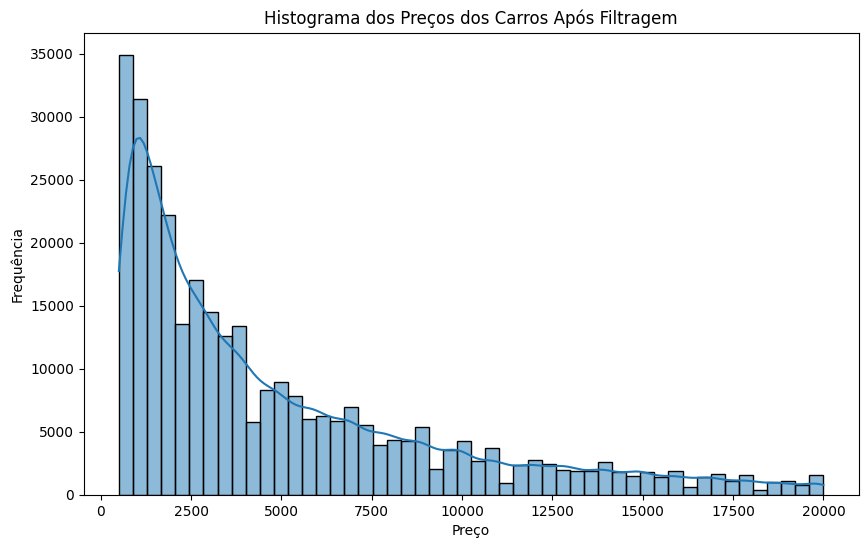

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Histograma dos Preços dos Carros Após Filtragem')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

#### Coluna power

Em breve pesquisa encontramos os carros com menores potência já fabricados e podemos observar que são raros os modelos abaixo de 30 hp. Considerando esses fatores, filtraremos o dataframe eliminando essas observações que nos trazem um valor menor do que 30.

**Carros de menor potência:**  

* Citroën 2CV (1948-1990): 9 hp
* Fiat 500 (1957-1975): 13 hp
* BMW Isetta (1955-1962): 12 hp
* Auto Union DKW Junior (1950-1958): 12 hp
* Goggomobil T300 (1959-1969): 13 hp
* Suzuki Alto (1979-presente): 31 hp (modelos iniciais)
* Smart Fortwo (1998-presente): 45 hp (modelos iniciais)  


Eliminaremos também, modelos que estejam com uma potência muito acima da normal. Apenas modelos superesportivos de marcas consagradas ultrapassam os 600hp. Por este motivo, vamos desconsiderar modelos acima de 600 hp.

**Carros esportivos com maior potência:**

* Porsche 911 Turbo S (2023): 650 cv
* Ferrari 812 Superfast (2023): 789 cv
* Lamborghini Huracán LP610-4 (2023): 610 cv
* Bugatti Chiron Super Sport 300+ (2019): 1.600 cv
* McLaren 720S (2019): 720 cv

In [27]:
df['power'].value_counts()

power
0        28470
75       20755
150      13834
60       12665
140      12577
         ...  
5867         1
2172         1
17410        1
584          1
1548         1
Name: count, Length: 666, dtype: int64

In [28]:
df['power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    33,    34,    35,    36,
          37,    38,    39,    40,    41,    42,    43,    44,    45,
          46,    47,    48,    49,    50,    51,    52,    53,    54,
          55,    56,    57,    58,    59,    60,    61,    62,    63,
          64,    65,    66,    67,    68,    69,    70,    71,    72,
          73,    74,    75,    76,    77,    78,    79,    80,    81,
          82,    83,    84,    85,    86,    87,    88,    89,    90,
          91,    92,    93,    94,    95,    96,    97,    98,    99,
         100,   101,   102,   103,   104,   105,   106,   107,   108,
         109,   110,   111,   112,   113,   114,   115,   116,   117,
         118,   119,   120,   121,   122,   123,   124,   125,   126,
         127,   128,

In [29]:
df_power_high = df.query("power > 600")

df_power_high.shape

(308, 10)

In [30]:
df_power_low = df.query("power < 30")

df_power_low.shape

(29204, 10)

In [31]:
df = df.query("power >= 30 and power <=600")
df.shape

(288128, 10)

### Análise individual das colunas categóricas

In [32]:
df.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no


#### coluna model

Não nos interessa avaliar observações que não contenham o modelo do automóvel, pois esta informação é crucial para quem faz buscas, assim como também é crucial para determinar o preço do veículo. Deste modo, iremos excluir as linhas com dados ausentes nesta coluna.

In [33]:
df = df.dropna(subset=['model'])
df['model'].isna().sum()

0

In [34]:
df.shape

(277462, 10)

In [35]:
df['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [36]:
df['model'].nunique()

249

In [37]:
df['model'].value_counts()

model
golf                  24364
other                 19385
3er                   17233
polo                   9661
corsa                  8853
                      ...  
i3                        4
serie_3                   3
samara                    3
rangerover                3
range_rover_evoque        2
Name: count, Length: 249, dtype: int64

Assim como vamos eliminar as linhas que contém informação ausente em relação ao modelo, também iremos eliminar aquelas que estejam preenchidas com 'other', pois esta informação também não nos interessa.

In [38]:
df = df[df['model']!= 'other']

df.shape

(258077, 10)

#### coluna vehicle_type

In [39]:
print(df['vehicle_type'].value_counts())
print()
print('ausentes:', df['vehicle_type'].isna().sum())

vehicle_type
sedan          72983
small          57778
wagon          53482
bus            21476
convertible    16530
coupe          10874
suv             8281
other           1542
Name: count, dtype: int64

ausentes: 15131


Temos uma quantidade muito grande de linhas com esta informação ausente. Essa informação de 'vehicle_type' pode ser inferida da coluna 'model', sendo que podemos verificar o modelo do carro e copiar o 'vehicle_type' que mais se repete para ele no DF. 

Poderíamos fazer essa tarefa com o algorítmo kNN, porém, como são mais de 30 mil linhas com informação ausente, isso levaria um tempo muito grande.

In [40]:
# Criar um dicionário para mapear modelos ao tipo de veículo mais comum
model_to_vehicle_type = df.dropna(subset=['vehicle_type']).groupby('model')['vehicle_type'].agg(lambda x: x.value_counts().index[0]).to_dict()

# Função para preencher os valores ausentes de 'vehicle_type'
def fill_vehicle_type(row):
    if pd.isna(row['vehicle_type']):
        return model_to_vehicle_type.get(row['model'], row['vehicle_type'])
    return row['vehicle_type']

# Aplicar a função ao DataFrame
df['vehicle_type'] = df.apply(fill_vehicle_type, axis=1)

df.sample(7)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
28499,10500,wagon,2010,manual,136,focus,125000,gasoline,ford,no
168954,8500,sedan,2007,auto,172,a6,150000,gasoline,audi,no
339759,3950,bus,2009,manual,125,modus,150000,petrol,renault,no
28681,10990,sedan,2010,manual,122,1er,80000,petrol,bmw,no
102815,18500,coupe,2008,NaN,250,tt,150000,petrol,audi,no
318596,7850,convertible,2011,auto,71,fortwo,50000,petrol,smart,no
245945,4999,small,2008,manual,84,fortwo,100000,petrol,smart,no


In [41]:
df['vehicle_type'].isna().sum()

0

In [42]:
df = df[df['vehicle_type'] != 'other']
df.shape

(256533, 10)

#### coluna fuel_type

In [43]:
print(df['fuel_type'].value_counts())
print()
print('ausentes:', df['fuel_type'].isna().sum())

fuel_type
petrol      158414
gasoline     80809
lpg           3842
cng            429
hybrid         117
other           30
electric        22
Name: count, dtype: int64

ausentes: 12870


In [44]:
df = df[df['fuel_type'] != 'other']

#### coluna gearbox

In [45]:
print(df['gearbox'].value_counts())
print()
print('ausentes:', df['gearbox'].isna().sum())

gearbox
manual    200252
auto       52115
Name: count, dtype: int64

ausentes: 4136


#### coluna not_repaired

In [46]:
print(df['not_repaired'].value_counts())
print()
print('ausentes:', df['not_repaired'].isna().sum())

not_repaired
no     201816
yes     20373
Name: count, dtype: int64

ausentes: 34314


Para as colunas 'fuel_type', 'gearbox' e 'not_repaired' não temos uma forma de inferir a informação exata e poderíamos inserir informações erradas. Deste modo, como temos muitas linhas, iremos removê-las.

In [47]:
df = df.dropna(subset=['fuel_type', 'gearbox', 'not_repaired'])

df.shape

(211817, 10)

In [48]:
print(df.isna().sum())

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
mileage              0
fuel_type            0
brand                0
not_repaired         0
dtype: int64


### Data Frame após pré-processamento

Agora renomeamos o DataFrame após finalizar todos os ajustes

In [49]:
df_clean = df

In [50]:
df_clean.sample(5)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
155637,10850,wagon,2008,manual,170,c_klasse,150000,gasoline,mercedes_benz,no
267103,950,wagon,2000,auto,131,omega,150000,gasoline,opel,no
249227,11900,bus,2005,auto,174,transporter,150000,gasoline,volkswagen,no
84648,8200,suv,2011,manual,110,duster,150000,gasoline,dacia,no
166192,2000,sedan,1999,manual,101,a3,5000,gasoline,audi,no


In [51]:
df_clean.describe()

,price,registration_year,power,mileage
count,211817.000000,211817.000000,211817.000000,211817.000000
mean,5456.894980,2003.876426,123.620271,126990.586214
std,4694.716626,5.726833,52.565641,36847.724393
min,500.000000,1961.000000,30.000000,5000.000000
25%,1750.000000,2000.000000,84.000000,125000.000000
50%,3900.000000,2004.000000,116.000000,150000.000000
75%,7900.000000,2008.000000,150.000000,150000.000000
max,20000.000000,2019.000000,600.000000,150000.000000


### Feature Engineering

In [52]:
# Criando um cópia do DataFrame para evitar warning
df_clean = df_clean.copy()

# Criando uma coluna 'power_x2'
df_clean.loc[:, 'power_x2'] = df_clean['power'] * 2

df_clean.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired,power_x2
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,150
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,138
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,204
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,218
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no,210


### Transformação dos dados

In [53]:
# Definindo as categorias
categoric = ['model', 'fuel_type', 'vehicle_type', 'brand']
numeric = ['price', 'power', 'mileage', 'registration_year', 'power_x2']
ordinal = ['gearbox', 'not_repaired']

#### Ordinal

##### gearbox

Carros automáticos de mesmo modelo e marca, tendem a ser mais caros do que os mesmos modelos em versão manual. Por este motivo, consideramos a coluna 'gearbox' como ordinal, onde manual é igual a 0 e auto é igual a 1. 

In [54]:
gearbox_dict = {'manual': 0, 'auto': 1}

df_clean['gearbox'] = df_clean['gearbox'].map(gearbox_dict)
df_clean['gearbox']

3         0
4         0
5         0
6         0
10        0
         ..
354096    0
354097    0
354100    0
354104    1
354105    0
Name: gearbox, Length: 211817, dtype: int64

In [55]:
df_clean['gearbox'].value_counts()

gearbox
0    167198
1     44619
Name: count, dtype: int64

##### not_repaired

Minha interpretação para essa coluna foi de que carros not_repaired, são carros que não tiveram a necessidade de reparos, ou não tiveram avarias. Portanto, estes carros seriam mais valorizados do que aqueles de mesmas características que precisaram de reparos ou sofreram avarias. Deste modo, definimos 'no' igual a 1 e 'yes' igual a 0.

In [56]:
repair_dict = {'no': 1, 'yes': 0}

df_clean['not_repaired'] = df_clean['not_repaired'].map(repair_dict)

In [57]:
df_clean['not_repaired'].value_counts()

not_repaired
1    192983
0     18834
Name: count, dtype: int64

In [58]:
df_clean.dtypes

price                 int64
vehicle_type         object
registration_year     int64
gearbox               int64
power                 int64
model                object
mileage               int64
fuel_type            object
brand                object
not_repaired          int64
power_x2              int64
dtype: object

### Tratamento tipos de dados

In [59]:
# Colunas para category
df_clean[['model', 'fuel_type', 'vehicle_type', 'brand']] = df_clean[
    ['model', 'fuel_type', 'vehicle_type', 'brand']].astype('category')

df_clean.dtypes

price                   int64
vehicle_type         category
registration_year       int64
gearbox                 int64
power                   int64
model                category
mileage                 int64
fuel_type            category
brand                category
not_repaired            int64
power_x2                int64
dtype: object

In [60]:
df_clean.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired,power_x2
3,1500,small,2001,0,75,golf,150000,petrol,volkswagen,1,150
4,3600,small,2008,0,69,fabia,90000,gasoline,skoda,1,138
5,650,sedan,1995,0,102,3er,150000,petrol,bmw,0,204
6,2200,convertible,2004,0,109,2_reihe,150000,petrol,peugeot,1,218
10,2000,sedan,2004,0,105,3_reihe,150000,petrol,mazda,1,210


#### One-Hot

In [61]:
# Definindo df com características categóricas para codificação One-Hot 
df_clean_categoric = pd.get_dummies(df_clean[categoric], drop_first=True)

# Ajustando demais DataFrames para concatenação
df_clean_numeric = df_clean[numeric]
df_clean_ordinal = df_clean[ordinal]

# Reiniciando os índices
df_clean_categoric.reset_index(drop=True, inplace=True)
df_clean_numeric.reset_index(drop=True, inplace=True)
df_clean_ordinal.reset_index(drop=True, inplace=True)

# Concatenando os DataFrames
df_concat = pd.concat([df_clean_categoric, df_clean_numeric, df_clean_ordinal], axis=1)

df_concat.head()

,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,...,brand_trabant,brand_volkswagen,brand_volvo,price,power,mileage,registration_year,power_x2,gearbox,not_repaired
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,1500,75,150000,2001,150,0,1
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,3600,69,90000,2008,138,0,1
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,650,102,150000,1995,204,0,0
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,2200,109,150000,2004,218,0,1
4,False,False,False,False,False,False,False,False,False,True,...,False,False,False,2000,105,150000,2004,210,0,1


#### Divisão dos dados

In [62]:
# Dividindo o DataFrame em características e objetivo
features = df_concat.drop("price", axis=1)
target = df_concat["price"]

# Na primeira etapa, dividiremos os dados em "treinamento" e "conjunto de dados restantes" 
features_train, features_remain, target_train, target_remain = train_test_split(
    features, target, train_size=0.7, random_state = 12345)

# Agora, queremos que os tamanhos dos conjuntos de validação e teste sejam iguais 
# Portanto, vamos definir test_size que represente 50% dos dados restantes
features_valid, features_test, target_valid, target_test = train_test_split(
    features_remain, target_remain, test_size=0.5, random_state = 12345)


print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(148271, 301)
(148271,)
(31773, 301)
(31773,)
(31773, 301)
(31773,)


### Padronização dos dados

In [63]:
numeric = ['power', 'mileage', 'registration_year']

In [64]:
features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()

scaler = StandardScaler()
features_train.loc[:, numeric[1:]] = scaler.fit_transform(features_train.loc[:, numeric[1:]])
features_valid.loc[:, numeric[1:]] = scaler.transform(features_valid.loc[:, numeric[1:]])
features_test.loc[:, numeric[1:]] = scaler.transform(features_test.loc[:, numeric[1:]])


features_train.head(3)

C:\Users\renan\AppData\Local\Temp\ipykernel_8432\3458923212.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.27744321  0.62338799 -1.54899053 ...  0.62338799  0.62338799
  0.62338799]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  features_train.loc[:, numeric[1:]] = scaler.fit_transform(features_train.loc[:, numeric[1:]])
C:\Users\renan\AppData\Local\Temp\ipykernel_8432\3458923212.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.54720743  0.19770457  1.42096459 ... -1.37505832 -1.02555546
 -0.6760526 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  features_train.loc[:, numeric[1:]] = scaler.fit_transform(features_train.loc[:, numeric[1:]])
C:\Users\renan\AppData\Local\Temp\ipykernel_8432\3458923212.py:7: FutureWarning: Setting an item of incomp

,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,...,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,power,mileage,registration_year,power_x2,gearbox,not_repaired
92424,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,95,-1.277443,0.547207,190,1,1
98253,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,218,0.623388,0.197705,436,1,1
178458,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,120,-1.548991,1.420965,240,0,1


## Treinamento dos modelos

### Regressão Linear

In [65]:
# Definindo o modelo de Regressão Linear
model_reg = LinearRegression()
model_reg.fit(features_train, target_train)
predict_valid_reg = model_reg.predict(features_valid)

# Medindo o tempo de treinamento do modelo
time_train_reg = timeit.timeit(lambda: model_reg.fit(features_train, target_train), number=1)

# Avaliando o modelo
reqm_train_reg = mean_squared_error(target_valid, predict_valid_reg, squared=False)
print('Reqm:', reqm_train_reg)
print(f'Tempo de execução: {time_train_reg} segundos')

Reqm: 2457.439495694943
Tempo de execução: 12.310902500059456 segundos


C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [66]:
# Predizendo os resultados com o modelo obtido
predict_test_reg = model_reg.predict(features_test)

# Medindo o tempo para predição
time_test_reg = timeit.timeit(lambda: model_reg.predict(features_test), number=1)

#Avaliando o modelo
reqm_test_reg = mean_squared_error(target_test, predict_test_reg, squared=False)
print('Reqm:', reqm_test_reg)
print(f'Tempo de execução: {time_test_reg} segundos')

Reqm: 2409.887840880788
Tempo de execução: 0.1734807000029832 segundos


C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Floresta Aleatória

In [67]:
# Definindo o modelo de Floresta Aleatória
model_forest = RandomForestRegressor(random_state=12345)

# Definindo a grade de hiperparâmetros
param_grid = {'n_estimators': [1, 2, 3, 4],
              'max_depth': [None, 1, 3, 5],
              'min_samples_split': [2, 4, 6]}

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=model_forest, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')


# Função para executar o ajuste do modelo
def fit_model_forest():
    grid_search.fit(features_train, target_train)

# Medindo o tempo de execução do treinamento
time_train_forest = timeit.timeit(fit_model_forest, number=1)

# Treinando o modelo e fazendo as predições
grid_search.fit(features_train, target_train)
best_model_forest = grid_search.best_estimator_
predict_valid_forest = best_model_forest.predict(features_valid)

# Avaliando o modelo
reqm_train_forest = mean_squared_error(target_valid, predict_valid_forest, squared=False)
print('REQM:', reqm_train_forest)
print('Melhores Hiperparâmetros:', grid_search.best_params_)
print(f'Tempo de execução: {time_train_forest} segundos')

REQM: 1576.3183040102738
Melhores Hiperparâmetros: {'max_depth': None, 'min_samples_split': 6, 'n_estimators': 4}
Tempo de execução: 267.7235814000014 segundos


C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [68]:
# Predizendo os resultados com o melhor modelo encontrado
predict_test_forest = best_model_forest.predict(features_test)

time_test_forest = timeit.timeit(lambda: best_model_forest.predict(features_test), number=1) 

reqm_test_forest = mean_squared_error(target_test, predict_test_forest, squared=False)
print('REQM:', reqm_test_forest)
print(f'Tempo de execução: {time_test_forest} segundos')

REQM: 1565.333397693155
Tempo de execução: 0.14128790004178882 segundos


C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### CatBoost

In [69]:
# Definindo o modelo de CatBoost
model_cat = CatBoostRegressor(random_seed=12345, loss_function='RMSE', early_stopping_rounds=10)
model_cat.fit(features_train, target_train)

# Definindo a grade de hiperparâmetros
param_grid = {'learning_rate': [0.1, 0.2, 0.3],
              'depth': [None, 3, 6, 10],
              'iterations': [50, 100, 150]}
    

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=model_cat, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')


# Função para executar o ajuste do modelo
def fit_model_cat():
    grid_search.fit(features_train, target_train, eval_set=(features_valid, target_valid), verbose=10, use_best_model=True)

# Medindo o tempo de execução do treinamento
time_train_cat = timeit.timeit(fit_model_cat, number=1)

# Treinando o modelo e fazendo as predições
grid_search.fit(features_train, target_train, eval_set=(features_valid, target_valid), verbose=10, use_best_model=True)
best_model_cat = grid_search.best_estimator_
predict_valid_cat = best_model_cat.predict(features_valid)

# Avaliando o modelo
reqm_train_cat = mean_squared_error(target_valid, predict_valid_cat, squared=False)
print('REQM:', reqm_train_cat)
print('Melhores Hiperparâmetros:', grid_search.best_params_)
print(f'Tempo de execução: {time_train_cat} segundos')

Learning rate set to 0.0902
0:	learn: 4413.7594366	total: 686ms	remaining: 11m 25s
1:	learn: 4158.0835986	total: 813ms	remaining: 6m 45s
2:	learn: 3925.3705550	total: 936ms	remaining: 5m 10s
3:	learn: 3722.7665071	total: 977ms	remaining: 4m 3s
4:	learn: 3545.4486639	total: 1s	remaining: 3m 20s
5:	learn: 3378.3765458	total: 1.07s	remaining: 2m 57s
6:	learn: 3232.4986659	total: 1.1s	remaining: 2m 35s
7:	learn: 3102.0112523	total: 1.15s	remaining: 2m 23s
8:	learn: 2982.3925417	total: 1.18s	remaining: 2m 10s
9:	learn: 2881.2215581	total: 1.21s	remaining: 2m
10:	learn: 2788.8110229	total: 1.24s	remaining: 1m 51s
11:	learn: 2703.4890691	total: 1.27s	remaining: 1m 44s
12:	learn: 2630.3031634	total: 1.3s	remaining: 1m 38s
13:	learn: 2563.0995231	total: 1.32s	remaining: 1m 33s
14:	learn: 2504.1324478	total: 1.35s	remaining: 1m 28s
15:	learn: 2451.4815319	total: 1.45s	remaining: 1m 29s
16:	learn: 2402.6614176	total: 1.48s	remaining: 1m 25s
17:	learn: 2361.0733363	total: 1.51s	remaining: 1m 22s
1

C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [70]:
# Medindo o tempo de execução das predições com o melhor modelo 
time_test_cat = timeit.timeit(lambda: best_model_cat.predict(features_test), number=1)

# Fazendo as predições com o melhor modelo
predict_test_cat = best_model_cat.predict(features_test)

# Avaliando o modelo
reqm_test_cat = mean_squared_error(target_test, predict_test_cat, squared=False)
print(f'Tempo de execução: {time_test_cat} segundos')
print('REQM:', reqm_test_cat)

Tempo de execução: 0.3562102001160383 segundos
REQM: 1472.3224104350868


C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### LightGBM 

In [71]:
# Definindo o modelo LGBM
model_lgb = lgb.LGBMRegressor(random_state=12345)

# Definindo a grade de hiperparâmetros
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [10, 30, 50],
    'n_estimators': [50, 100, 150],
    'max_depth': [-1, 5, 10]}

# Configurando o GridSearchCV
grid_search = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error')

# Função callback para logging
callbacks = [lgb.log_evaluation(period=10), lgb.early_stopping(stopping_rounds=10)]

# Função para ajustar o modelo
def fit_model():
    grid_search.fit(
        features_train, target_train,
        eval_set=[(features_valid, target_valid)],
        eval_metric='rmse',
        callbacks=callbacks)

# Medindo o tempo de execução
time_train_lgb = timeit.timeit(fit_model, number=1)

# Treinando o modelo
fit_model()
best_model_lgb = grid_search.best_estimator_

# Fazendo as predições e avaliando o modelo
predict_valid_lgb = best_model_lgb.predict(features_valid)
reqm_train_lgb = mean_squared_error(target_valid, predict_valid_lgb, squared=False)

print(f'Tempo de execução: {time_train_lgb} segundos')
print('REQM:', reqm_train_lgb)
print('Melhores Hiperparâmetros:', grid_search.best_params_)

In [ ]:
# Fazendo as predições com o melhor modelo
predict_test_lgb = best_model_lgb.predict(features_test)

# Medindo o tempo de execução
time_test_lgb = timeit.timeit(lambda: best_model_lgb.predict(features_test), number=1)

# Avaliando o modelo
reqm_test_lgb = mean_squared_error(target_test, predict_test_lgb, squared=False)
print(f'Tempo de execução: {time_test_lgb} segundos')
print('REQM:', reqm_test_lgb)

## Análise dos modelos

In [ ]:
results = {
    'model': ['Regressão Linear', 'Floresta Aleatória', 'CatBoost', 'LightGBM'],
    'REQM_train_valid': [reqm_train_reg, reqm_train_forest, reqm_train_cat, reqm_train_lgb],
    'REQM_test': [reqm_test_reg, reqm_test_forest, reqm_test_cat, reqm_test_lgb],
    'time_train_valid_(s)': [time_train_reg, time_train_forest, time_train_cat, time_train_lgb],
    'time_test_(s)': [time_test_reg, time_test_forest, time_test_cat, time_test_lgb]}

df_results = pd.DataFrame(results)
df_results = df_results.set_index('model')
df_results

In [ ]:
df_reqm = df_results[['REQM_train_valid', 'REQM_test']]

df_time = df_results[['time_train_valid_(s)', 'time_test_(s)']]

In [ ]:
# Plotando um gráfico de barras para visualização dos dados de vendas das plataformas top-5 ao longo dos anos
ax = df_reqm.plot(kind='bar',
                    figsize=[10, 4],
                    width=0.4)

# Ajustando o título e os rótulos dos eixos
ax.set_title('RESULTADOS DE REQM OBTIDOS', fontsize=14, weight='bold', pad=20)
ax.set_xlabel('MODELOS', fontsize=14, labelpad=10, weight='bold')
ax.set_ylabel('REQM', fontsize=14, labelpad=10, weight='bold')

# Rotacionando os rótulos do eixo x
ax.set_xticklabels(df_reqm.index, rotation=0)

# Ajustando o tamanho dos rótulos dos eixos
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Adicionando gridlines
ax.grid(True, which='both', linestyle='--', linewidth=1, axis='y')

# Posicionando a legenda fora do gráfico
ax.legend(['Treino', 'Teste'], fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Exibindo o gráfico
plt.show()

**Conclusões:**  

Os melhores resultados obtidos foram os dos modelos CatBoost e LGBM. Porém, o resultado obtido pelo modelo Floresta Aleatória também foi aceitável. O pior resultado de REQM foi o do modelo de Regressão Linear, apresentando um erro muito maior do que o dos outros modelos treinados.

In [ ]:
# Plotando um gráfico de barras para visualização dos dados de vendas das plataformas top-5 ao longo dos anos
ax = df_time['time_train_valid_(s)'].plot(kind='bar',
                                          figsize=[10, 4],
                                          width=0.4,
                                          legend=False)

# Ajustando o título e os rótulos dos eixos
ax.set_title('TEMPO PARA TREINAMENTO DOS MODELOS', fontsize=14, weight='bold', pad=20)
ax.set_xlabel('MODELOS', fontsize=10, labelpad=10, weight='bold')
ax.set_ylabel('TEMPO (s)', fontsize=10, labelpad=10, weight='bold')

# Rotacionando os rótulos do eixo x
ax.set_xticklabels(df_time['time_train_valid_(s)'].index, rotation=0)

# Ajustando o tamanho dos rótulos dos eixos
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Adicionando gridlines
ax.grid(True, which='both', linestyle='--', linewidth=1, axis='y')


# Exibindo o gráfico
plt.show()

**Conclusões:**  

Em relação ao tempo de treinamento dos modelos observamos que o melhor desempenho, com larga vantagem, é o do modelo de Regressão Linear, que demorou apenas 12 segundos. O segundo melhor desempenho foi do modelo de Floresta Aleatória, mas já consumindo um tempo de 370 segundos (30 vezes maior do que o tempo gasto pela Regressão Linear). Em seguida, tivemos o modelo CatBoost, que consumiu um tempo de 550 segundos (45 vezes mais do que o modelo de Regressão) e, por último, o modelo de LGBM, que levou 1220 segundos para o treinamento do modelo (mais do que o dobro do tempo gasto pelo CatBoost e mais de 100 vezes o tempo gasto pela Regressão Linear).


In [ ]:
# Plotando um gráfico de barras para visualização dos dados de vendas das plataformas top-5 ao longo dos anos
ax = df_time['time_test_(s)'].plot(kind='bar',
                                          figsize=[10, 4],
                                          width=0.4,
                                          legend=False)

# Ajustando o título e os rótulos dos eixos
ax.set_title('TEMPO PARA PREDIÇÃO COM DADOS DE TESTE', fontsize=14, weight='bold', pad=20)
ax.set_xlabel('MODELOS', fontsize=10, labelpad=10, weight='bold')
ax.set_ylabel('TEMPO (s)', fontsize=10, labelpad=10, weight='bold')

# Rotacionando os rótulos do eixo x
ax.set_xticklabels(df_time['time_test_(s)'].index, rotation=0)

# Ajustando o tamanho dos rótulos dos eixos
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Adicionando gridlines
ax.grid(True, which='both', linestyle='--', linewidth=1, axis='y')


# Exibindo o gráfico
plt.show()

**Conclusões:**

Em relação ao tempo para predição com os dados de teste, todos os modelos apresentaram resultados satisfatórios, pois todos estiveram abaixo de 1 segundo. Porém, se compararmos uns com os outros, podemos observar que o modelo CatBoost apresentou um desempenho melhor, sendo de 0.08 segundo, seguido por Regressão Linear (0.1 s), Floresta Aleatória (0.15 s) e LGBM, que apresentou de longe o pior desempenho (0.61 s).

Para este conjunto de dados, o desempenho de todos foi aceitável. Porém, se considerarmos um conjunto de dados muito maior, com milhões ou bilhões de linhas, o desempenho pode ser mais impactado. Portanto, o modelo CatBoost apresentaria um resultado melhor nesses casos.

## Conclusões Finais

**O melhor desempenho dentre os modelos, analisando-se os resultados de REQM e o tempo, foi o do modelo CatBoost.**

O modelo de Regressão Linear apresentou um resultado muito melhor em relação ao tempo de treinamento do modelo. Porém, o resultado de REQM não foi aceitável se comparado aos demais modelos.

Os resultados de REQM obtidos foram muito parecidos entre os modelos CatBoost e LGBM. Porém, o tempo gasto pelo modelo LGBM foi muito maior, sendo mais que o dobro do tempo gasto pelo CatBoost. Por este motivo, o modelo CatBoost foi considerado o modelo que apresentou o melhor desempenho